In [1]:
# PROJECT/IMPLEMENTATION IDEAS
# 1. Historical market cap, % bitcoin (requires crawling https://coinmarketcap.com/historical/)
# 2. Twitter sentiment analysis of Bitcoin vs price
# 3. Bitcoin vs. altcoin market caps
# 4. Transaction fees, user/address count(?), other features(?) vs bitcoin price
# 5. Usage by country
# 6. Bitcoin trading by exchange
# 7. Bitcoin trading by currency
# 8. Increase in leverage?

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from pandas.core import datetools
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import dateutil.parser
from pprint import pprint
import json
import time
import sys
import re
import datetime

# APIs
# import quandl
# import coinmarketcap

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Helper functions
def to_currency(int):
    return "${:,.0f}".format(int//1000000)

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def list_to_average(list):
    try:
        avg = list[0]/list[1]
    except:
        avg = 0
    return avg

# def none_to_value(num):
#     if num == None:
#         num = 


In [4]:
df = pd.read_pickle('benson_btcsentiment_df.pkl')
df = df[['logBTCPrice','logETHPrice','BTCVol','TxFees','CostperTxn','NoTxns','AvgBlkSz','UniqueAddresses','HashRate','logCrypto Market Cap','logNasdaq','logGold','Interest']]
df_all = df
df_hist = df
df.head()

,logBTCPrice,logETHPrice,BTCVol,TxFees,CostperTxn,NoTxns,AvgBlkSz,UniqueAddresses,HashRate,logCrypto Market Cap,logNasdaq,logGold,Interest
Date,,,,,,,,,,,,,
2016-07-13,6.487181,2.356126,871225.091442,34693.70,5.69,219034.0,0.77,379937.0,1516960.89,23.229166,8.518339,5.425787,3.0
2016-07-14,6.486362,2.350422,872834.409470,35233.50,5.06,218093.0,0.81,367252.0,1379055.35,23.229166,8.523982,5.424421,3.0
2016-07-15,6.498043,2.442347,756558.628070,38613.99,5.49,220655.0,0.79,367953.0,1506352.77,23.229166,8.523094,5.411646,3.0
2016-07-17,6.498043,2.442347,756558.628070,38613.99,5.49,220655.0,0.79,367953.0,1506352.77,23.279152,8.523094,5.411646,3.0
2016-07-18,6.522313,2.429218,752528.346010,32557.41,7.59,171013.0,0.70,330330.0,1580609.59,23.279152,8.528287,5.413564,3.0


In [5]:
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logETHPrice,BTCVol,TxFees,CostperTxn,NoTxns,AvgBlkSz,UniqueAddresses,HashRate,logCrypto Market Cap,logNasdaq,logGold,Interest
BTCVol,-0.331613,-0.452007,1.000000,-0.158632,-0.236857,0.022006,-0.141422,-0.150644,-0.296667,-0.367307,-0.411523,-0.249095,-0.194530
logGold,-0.301767,-0.236081,-0.249095,-0.106519,-0.142027,-0.376338,-0.372461,-0.369234,-0.209758,-0.273772,-0.352965,1.000000,-0.199172
NoTxns,0.459889,0.302439,0.022006,0.463194,0.384812,1.000000,0.641586,0.869105,0.448159,0.390941,0.430019,-0.376338,0.560159
AvgBlkSz,0.611547,0.529283,-0.141422,0.486608,0.509786,0.641586,1.000000,0.692279,0.541980,0.582168,0.627325,-0.372461,0.538525
TxFees,0.716506,0.587610,-0.158632,1.000000,0.894105,0.463194,0.486608,0.733519,0.742455,0.693147,0.612035,-0.106519,0.804043
UniqueAddresses,0.783919,0.648355,-0.150644,0.733519,0.720936,0.869105,0.692279,1.000000,0.761295,0.733804,0.733726,-0.369234,0.811812
Interest,0.838540,0.688092,-0.194530,0.804043,0.878504,0.560159,0.538525,0.811812,0.820718,0.788577,0.725350,-0.199172,1.000000
CostperTxn,0.885625,0.767205,-0.236857,0.894105,1.000000,0.384812,0.509786,0.720936,0.927777,0.867026,0.797942,-0.142027,0.878504
logETHPrice,0.935532,1.000000,-0.452007,0.587610,0.767205,0.302439,0.529283,0.648355,0.849646,0.969836,0.941798,-0.236081,0.688092
HashRate,0.937355,0.849646,-0.296667,0.742455,0.927777,0.448159,0.541980,0.761295,1.000000,0.928017,0.904779,-0.209758,0.820718


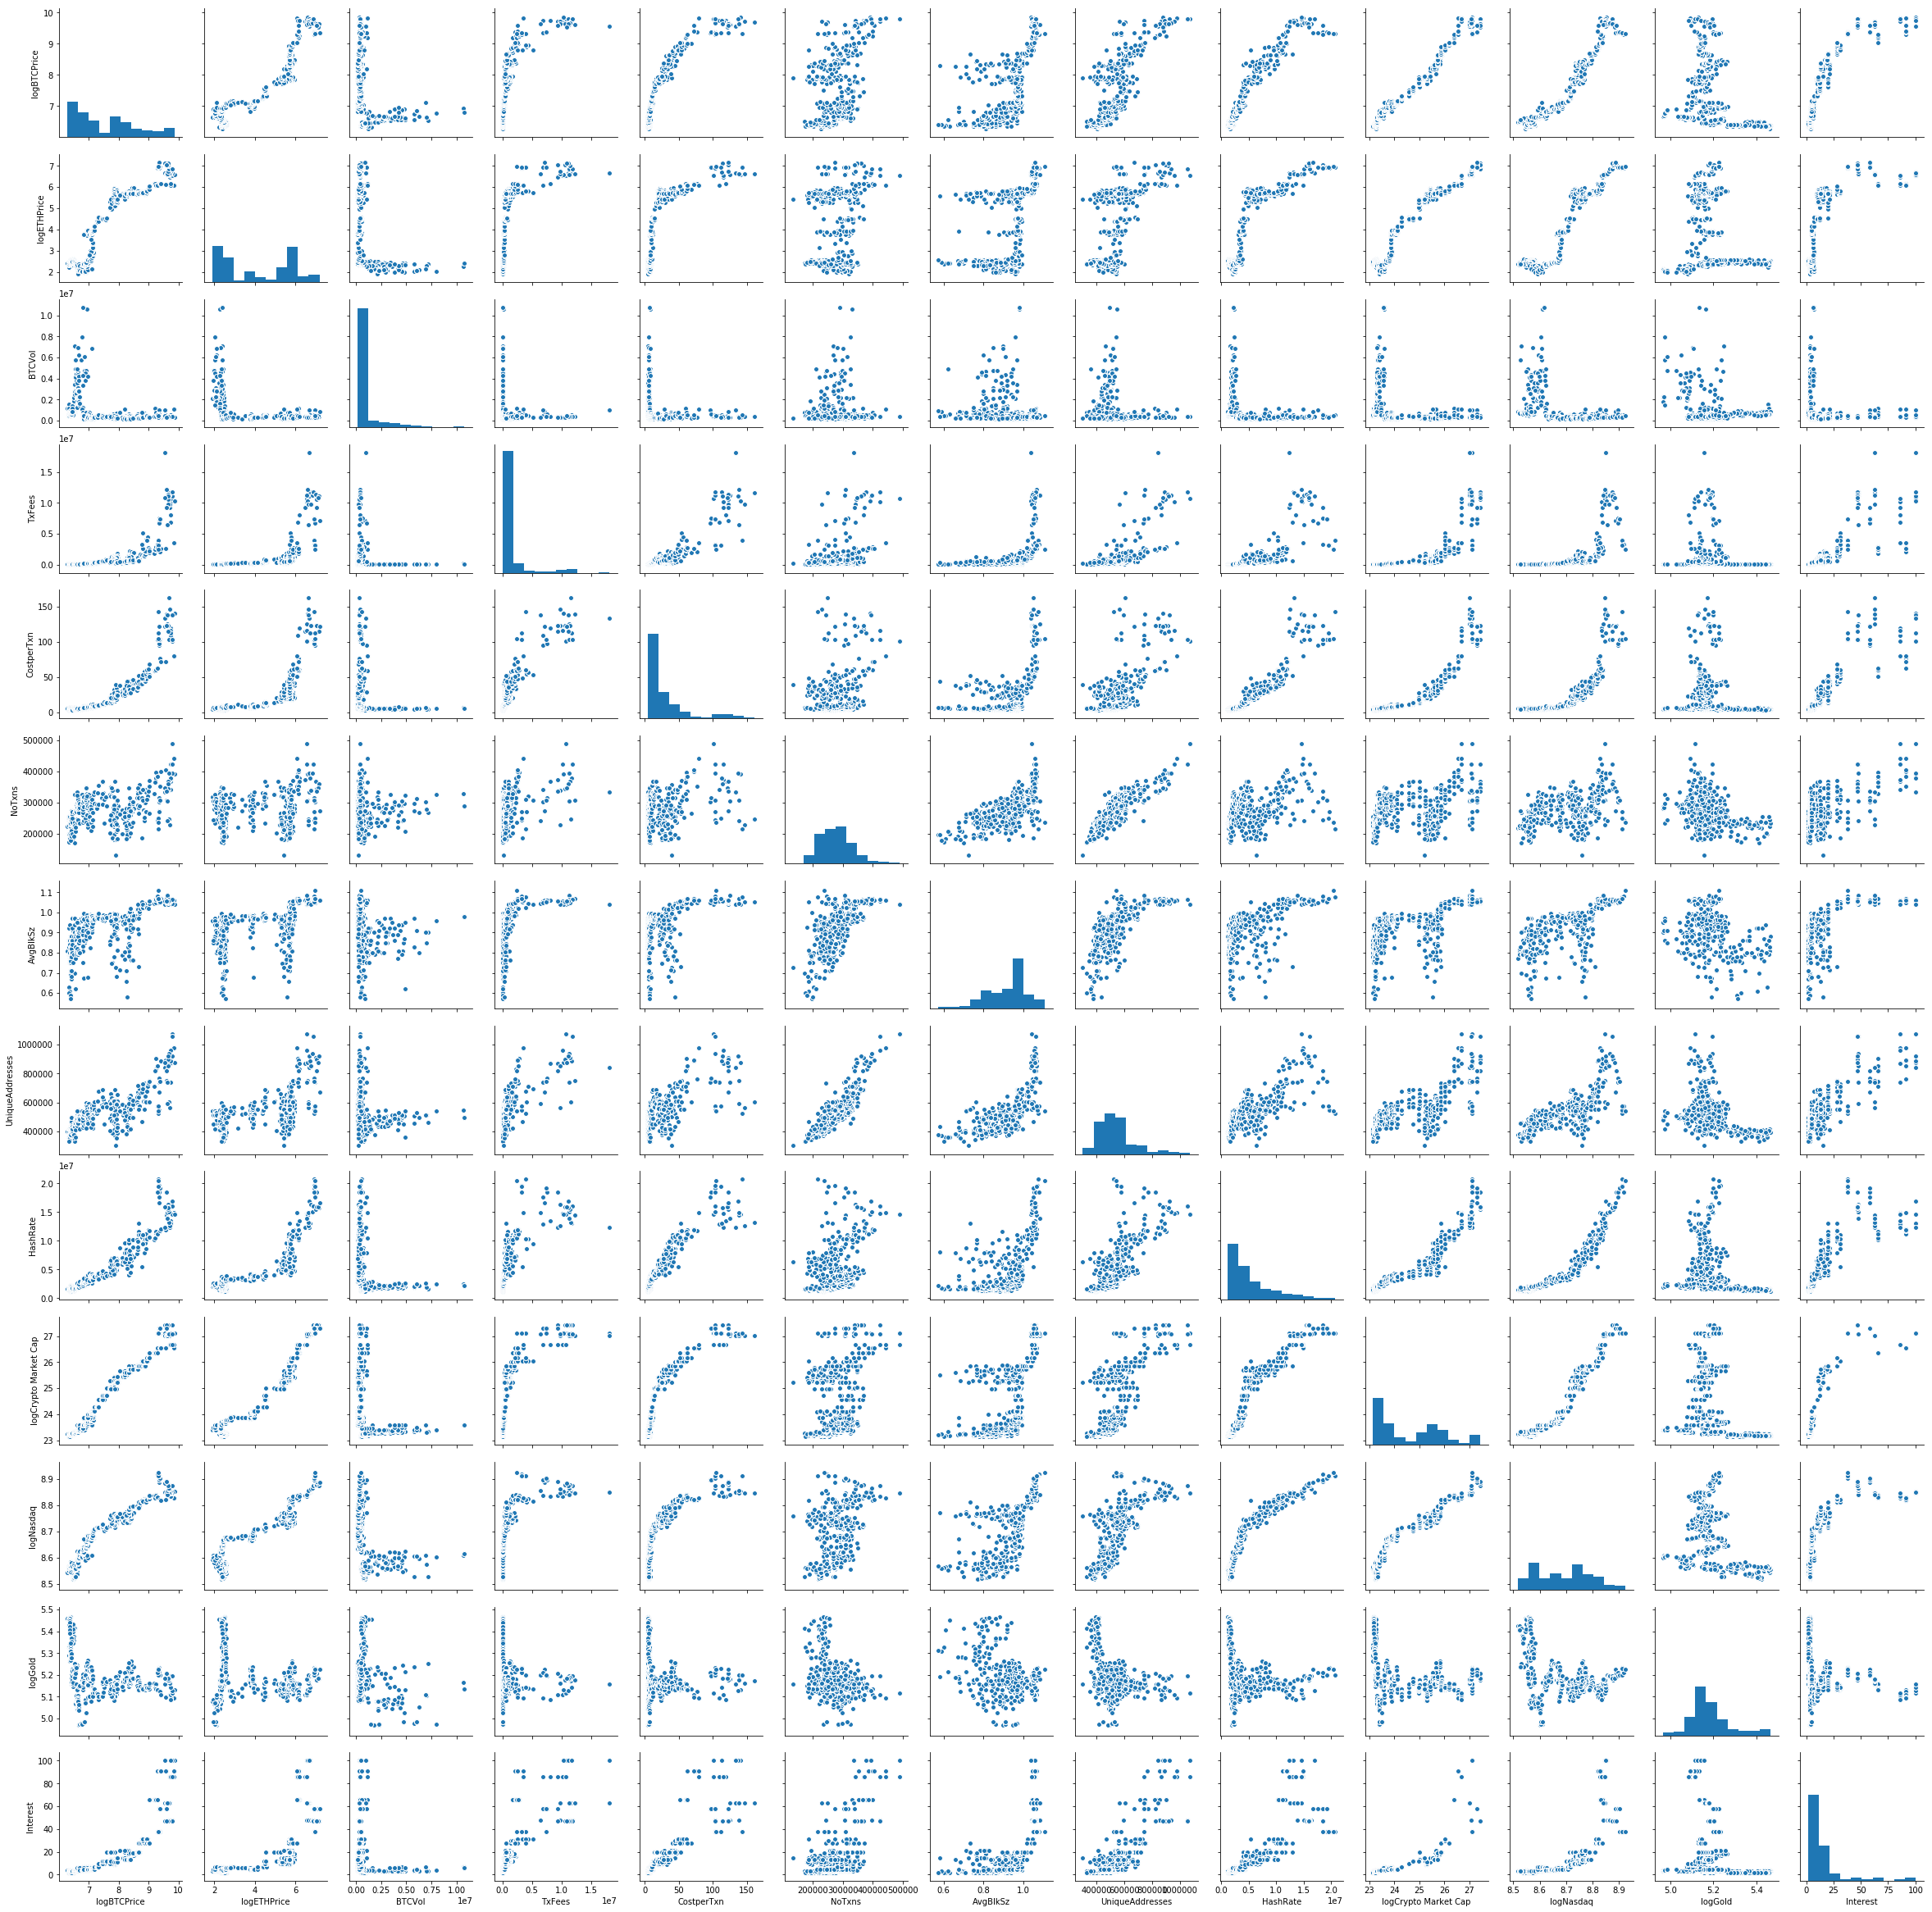

In [6]:
sns.pairplot(df_all)

In [7]:
# Reducing to few key features
df_all = df_all[['logBTCPrice','logNasdaq','Interest']]
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logNasdaq,Interest
Interest,0.838540,0.725350,1.00000
logNasdaq,0.957887,1.000000,0.72535
logBTCPrice,1.000000,0.957887,0.83854


'\nPossible leading indicators:\nGoogle Search Interest\n\n\nFollowing Indicators:\nCost per Transaction\nCrypto Market Cap\nEthereum Price\n'

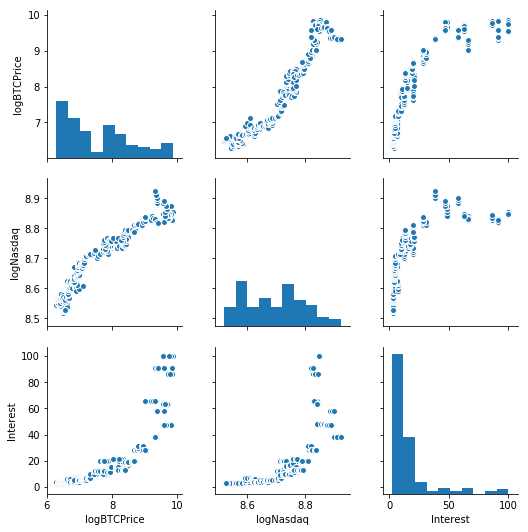

In [8]:
sns.pairplot(df_all)
'''
Possible leading indicators:
Google Search Interest


Following Indicators:
Cost per Transaction
Crypto Market Cap
Ethereum Price
'''

In [9]:
df = df_all
# STATSMODELS
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('logBTCPrice ~ Interest + logNasdaq', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     5677.
Date:                Mon, 29 Jan 2018   Prob (F-statistic):               0.00
Time:                        16:23:19   Log-Likelihood:                 84.307
No. Observations:                 462   AIC:                            -162.6
Df Residuals:                     459   BIC:                            -150.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -56.6894      1.152    -49.211      0.000     -58.953     -54.426
Interest       0.0156      0.001     22.695      0.000       0.014       0.017
logNasdaq      7.3651      0.133     55.207      0.000       7.103       7.627
==============================================================================
Omnibus:                       22.030   Durbin-Watson:                   0.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.830
Skew:                           0.090   Prob(JB):                      0.00734
Kurtosis:                       2.309   Cond. No.                     3.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

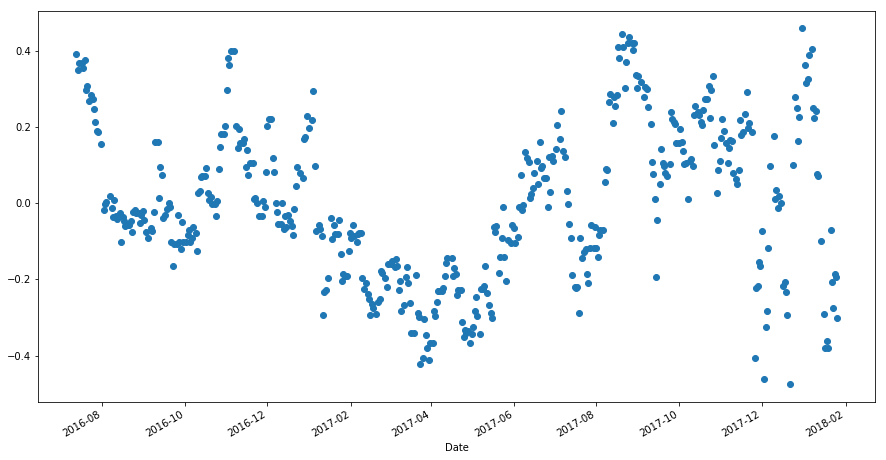

In [10]:
# Use statsmodels to plot the residuals
# NOTE THAT THIS IS A BAD FIT AS RESIDUALS ARE NOT RANDOM; NONLINEAR REGRESSION MAY BE REQUIRED
fit.resid.plot(style='o', figsize=(15,8));

In [11]:
# Create an empty model
lr1 = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['Interest','logNasdaq']]
# Choose the response variable(s)
y = df['logBTCPrice']
# Fit the model to the full dataset
lr1.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr1.score(X,y))
print(lr1.intercept_)
print(lr1.coef_)

0.9611462169571525
-56.68943729447204
[0.01555924 7.36505339]


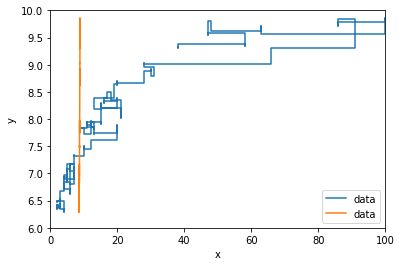

In [14]:
# plt.plot(X,y)
fig,ax = plt.subplots(1,1);

# ax.scatter(X, y)
ax.plot(X,y,label='data')
# plt.title("Title",fontsize=16)
# plt.xlabel('X', fontsize=12)
# plt.ylabel('Y', fontsize=12)
# plt.tight_layout()
# plt.savefig('charts/EthereumPrice2017a.png')
# plt.show()
ax.set_ylim((6, 10))
ax.set_xlim((0, 100))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

In [13]:
# Resources
# https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
# http://cs229.stanford.edu/proj2015/029_report.pdf
# http://text-processing.com/ API
# https://trends.google.com/trends/explore?q=bitcoin,ethereum